## Setup

In [1]:
from pathlib import Path
import sys

In [2]:
# Add src to path
sys.path.insert(0, str(Path('../src').absolute()))

In [3]:
from env_embeddings.rf_analysis import (
  load_source_data,
  analyze_source,
  create_comparison_table,
  print_summary,
)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## Load Data Sources

In [6]:
# Define data sources (GOLD and NMDC first, NCBI later)
SOURCES = {
  'GOLD': Path('../data/gold_flattened_biosamples_for_env_embeddings_202510061108_complete.csv'),
  'NMDC': Path('../data/nmdc_flattened_biosample_for_env_embeddings_202510061052_complete.csv'),
  'NCBI-partial': Path('../data/ncbi_flattened_biosamples_for_env_embeddings_202510061108_normalized_complete.csv'),
}

In [7]:
# Load all data WITHOUT deduplication first (more efficient)
datasets_no_dedup = {}
for source_name, file_path in SOURCES.items():
  df = load_source_data(file_path, source_name, deduplicate=False)
  if df is not None:
    datasets_no_dedup[source_name] = df


Loading GOLD
  Loaded: 10,401 rows
  Complete data: 10,401 rows
  Valid embeddings: 10,401 rows

  ENVO scale class counts:
    env_broad_scale     :   40 classes
    env_local_scale     :  139 classes
    env_medium          :   78 classes

Loading NMDC
  Loaded: 8,121 rows
  Complete data: 8,121 rows
  Valid embeddings: 8,121 rows

  ENVO scale class counts:
    env_broad_scale     :   19 classes
    env_local_scale     :   51 classes
    env_medium          :   30 classes

Loading NCBI-partial
  Loaded: 382,955 rows
  Complete data: 382,955 rows
  Valid embeddings: 382,955 rows

  ENVO scale class counts:
    env_broad_scale     :  570 classes
    env_local_scale     :  829 classes
    env_medium          :  562 classes


In [8]:
# Create deduplicated versions from loaded data (in-memory, no re-reading CSV)
datasets_dedup = {}
for source_name, df in datasets_no_dedup.items():
  print(f"\nDeduplicating {source_name}...")
  initial_count = len(df)
  df_dedup = df.drop_duplicates(
    subset=[
      "latitude",
      "longitude",
      "collection_date",
      "env_broad_scale",
      "env_local_scale",
      "env_medium",
    ],
    keep="first",
  ).copy()
  removed = initial_count - len(df_dedup)
  pct_removed = removed / initial_count * 100
  print(f"  {len(df_dedup):,} rows (removed {removed:,} = {pct_removed:.1f}%)")
  datasets_dedup[source_name] = df_dedup


Deduplicating GOLD...
  4,198 rows (removed 6,203 = 59.6%)

Deduplicating NMDC...
  4,646 rows (removed 3,475 = 42.8%)

Deduplicating NCBI-partial...
  73,197 rows (removed 309,758 = 80.9%)


# Remove NCBI from no-dedup version (too large to train on 382K rows)
if 'NCBI-partial' in datasets_no_dedup:
    print("\nRemoving NCBI-partial from non-dedup version (too large)")
    del datasets_no_dedup['NCBI-partial']

In [9]:
# Load non-deduplicated data for comparison (skip NCBI - too large)
datasets_no_dedup = {}
for source_name, file_path in SOURCES.items():
  if source_name == 'NCBI-partial':
    print(f"\nSkipping {source_name} for non-dedup version (too large)")
    continue
  df = load_source_data(file_path, source_name, deduplicate=False)
  if df is not None:
    datasets_no_dedup[source_name] = df


Loading GOLD
  Loaded: 10,401 rows
  Complete data: 10,401 rows
  Valid embeddings: 10,401 rows

  ENVO scale class counts:
    env_broad_scale     :   40 classes
    env_local_scale     :  139 classes
    env_medium          :   78 classes

Loading NMDC
  Loaded: 8,121 rows
  Complete data: 8,121 rows
  Valid embeddings: 8,121 rows

  ENVO scale class counts:
    env_broad_scale     :   19 classes
    env_local_scale     :   51 classes
    env_medium          :   30 classes

Skipping NCBI-partial for non-dedup version (too large)


In [10]:
# Train models for all sources (deduplicated)
all_results = {}
for source_name, df in datasets_dedup.items():
  all_results[source_name] = analyze_source(df, source_name)


------------------------------------------------------------
Training models: GOLD
------------------------------------------------------------

  env_broad_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  38 | Test acc: 0.807 | CV: 0.816±0.045 | Overfit: +0.095

  env_local_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 130 | Test acc: 0.670 | CV: 0.669±0.029 | Overfit: +0.197

  env_medium...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  72 | Test acc: 0.723 | CV: 0.731±0.014 | Overfit: +0.148

------------------------------------------------------------
Training models: NMDC
------------------------------------------------------------

  env_broad_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  18 | Test acc: 0.958 | CV: 0.955±0.009 | Overfit: +0.039

  env_local_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  50 | Test acc: 0.831 | CV: 0.837±0.013 | Overfit: +0.103

  env_medium...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  28 | Test acc: 0.858 | CV: 0.878±0.005 | Overfit: +0.093

------------------------------------------------------------
Training models: NCBI-partial
------------------------------------------------------------

  env_broad_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 555 | Test acc: 0.293 | CV: 0.301±0.033 | Overfit: +0.055

  env_local_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 806 | Test acc: 0.256 | CV: 0.289±0.021 | Overfit: +0.059

  env_medium...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 536 | Test acc: 0.311 | CV: 0.310±0.032 | Overfit: +0.075


## Results Summary

In [11]:
# Create comparison table
comparison_df = create_comparison_table(all_results)

In [12]:
print("\nDetailed Results:")
print(comparison_df.to_string(index=False))


Detailed Results:
      Source       Scale  Classes  Samples  Test_Acc  CV_Mean   CV_Std  Overfitting
        GOLD broad_scale       38     4198  0.807143 0.815658 0.022729     0.095478
        GOLD local_scale      130     4198  0.670238 0.668856 0.014300     0.197243
        GOLD      medium       72     4198  0.722619 0.731388 0.007054     0.147542
        NMDC broad_scale       18     4646  0.958065 0.955328 0.004697     0.038975
        NMDC local_scale       50     4646  0.831183 0.836651 0.006426     0.102617
        NMDC      medium       28     4646  0.858065 0.878363 0.002373     0.093496
NCBI-partial broad_scale      555    73197  0.292896 0.301348 0.016440     0.054902
NCBI-partial local_scale      806    73197  0.256079 0.289018 0.010379     0.058845
NCBI-partial      medium      536    73197  0.311475 0.309578 0.016015     0.074781


In [13]:
# Print actionable summary
print_summary(comparison_df)



SUMMARY: Random Forest ENVO Prediction Performance

Overall mean test accuracy: 0.634

Best:  NMDC   broad_scale  = 0.958
Worst: NCBI-partial local_scale  = 0.256

Performance by source:
  GOLD  : 0.733 avg, +0.147 overfit
  NMDC  : 0.882 avg, +0.078 overfit
  NCBI-partial: 0.287 avg, +0.063 overfit

Performance by scale:
  broad_scale : 0.686 avg, 204 avg classes
  local_scale : 0.586 avg, 329 avg classes
  medium      : 0.631 avg, 212 avg classes

ACTIONABLE INSIGHTS

~ Satellite embeddings have MODERATE predictive power
⚠️  High overfitting detected (max=0.197) - consider regularization

⚠️  Large variation across sources (std=0.310) - data quality differs


## Visualization: Test Accuracy by Scale

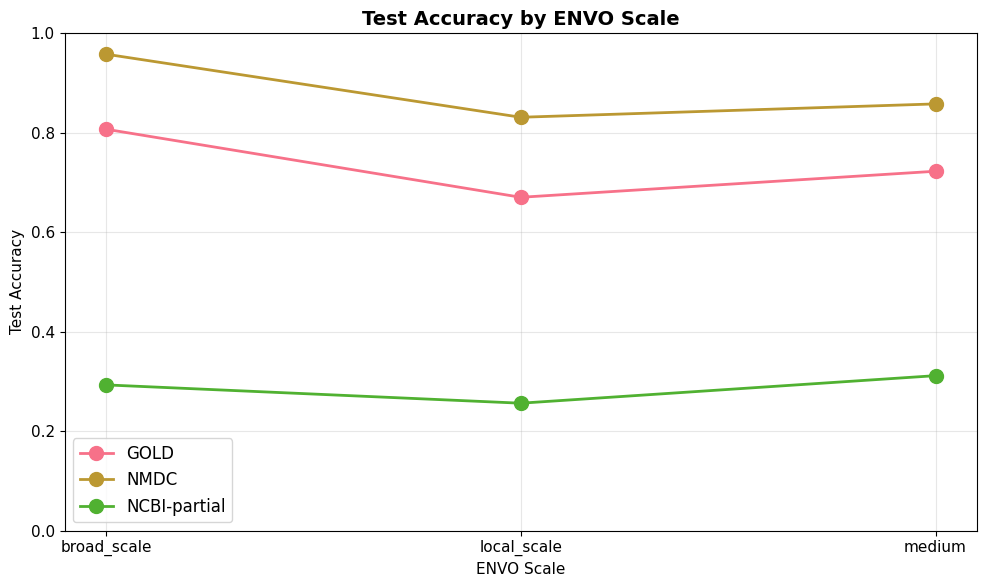

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

for source in comparison_df['Source'].unique():
  data = comparison_df[comparison_df['Source'] == source]
  ax.plot(data['Scale'], data['Test_Acc'],
          marker='o', linewidth=2, markersize=10, label=source)

ax.set_title('Test Accuracy by ENVO Scale', fontsize=14, fontweight='bold')
ax.set_xlabel('ENVO Scale')
ax.set_ylabel('Test Accuracy')
ax.set_ylim(0, 1.0)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization: Average Accuracy by Source

In [15]:
avg_by_source = comparison_df.groupby('Source')['Test_Acc'].mean()

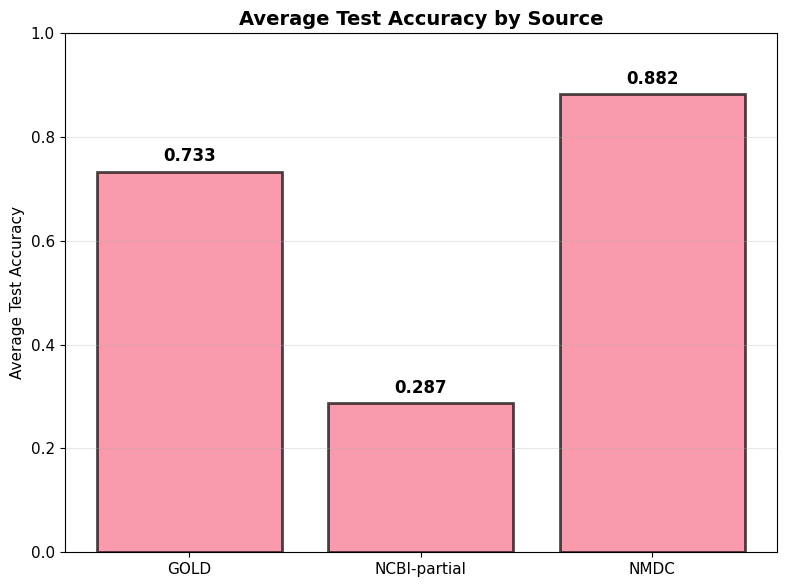

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(avg_by_source.index, avg_by_source.values,
              alpha=0.7, edgecolor='black', linewidth=2)
ax.set_title('Average Test Accuracy by Source', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Test Accuracy')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width() / 2., height + 0.02,
          f'{height:.3f}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

## Visualization: Overfitting Check

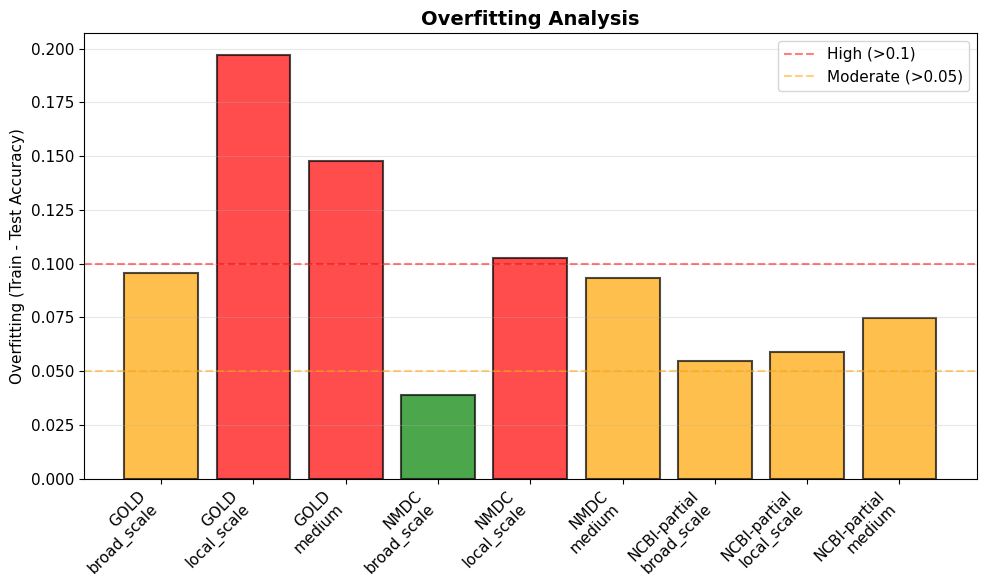

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Color bars by overfitting severity
colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green'
          for x in comparison_df['Overfitting'].values]

x_labels = [f"{row['Source']}\n{row['Scale']}"
            for _, row in comparison_df.iterrows()]

bars = ax.bar(range(len(comparison_df)), comparison_df['Overfitting'].values,
              color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(comparison_df)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_ylabel('Overfitting (Train - Test Accuracy)')
ax.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High (>0.1)')
ax.axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Moderate (>0.05)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [18]:
output_dir = Path('../results/rf_multi_source')
output_dir.mkdir(parents=True, exist_ok=True)

In [19]:
output_file = output_dir / 'comparison_results.csv'
comparison_df.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

Results saved to: ../results/rf_multi_source/comparison_results.csv


In [20]:
# Import per-class performance function
from env_embeddings.rf_analysis import print_class_performance

In [21]:
# Show per-class performance for each source
for source_name in all_results:
  print_class_performance(all_results[source_name], source_name)



PER-CLASS PERFORMANCE: GOLD


env_broad_scale:
  Total classes: 30
  Macro avg F1: 0.715
  Weighted avg F1: 0.815

  High performers (F1 > 0.9): 11 classes
    ENVO:01000035: F1=1.000, support=11
    ENVO:01000030: F1=1.000, support=1
    ENVO:01000176: F1=1.000, support=6
    ENVO:01000049: F1=1.000, support=1
    ENVO:01000249: F1=1.000, support=4

  Poor performers (F1 < 0.3): 3 classes
    ENVO:00000044: F1=0.000, support=1
    ENVO:01000181: F1=0.000, support=2
    ENVO:01001835: F1=0.000, support=1

  ⚠️  Classes with 0% F1 (completely failed): 3
      These are likely rare classes that need more samples or parent grouping

env_local_scale:
  Total classes: 116
  Macro avg F1: 0.392
  Weighted avg F1: 0.678

  High performers (F1 > 0.9): 14 classes
    ENVO:00000033: F1=1.000, support=4
    ENVO:00000195: F1=1.000, support=1
    ENVO:00000137: F1=1.000, support=2
    ENVO:00000055: F1=1.000, support=2
    ENVO:00000150: F1=1.000, support=1

  Poor performers (F1 < 0.3): 55 clas

## Deduplication Impact Analysis

In [22]:
# Train models on non-deduplicated data
all_results_no_dedup = {}
for source_name, df in datasets_no_dedup.items():
  all_results_no_dedup[source_name] = analyze_source(df, f"{source_name}-NoDedup")


------------------------------------------------------------
Training models: GOLD-NoDedup
------------------------------------------------------------

  env_broad_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  40 | Test acc: 0.914 | CV: 0.925±0.014 | Overfit: +0.035

  env_local_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 136 | Test acc: 0.810 | CV: 0.782±0.016 | Overfit: +0.035

  env_medium...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  76 | Test acc: 0.824 | CV: 0.817±0.041 | Overfit: +0.045

------------------------------------------------------------
Training models: NMDC-NoDedup
------------------------------------------------------------

  env_broad_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  19 | Test acc: 0.966 | CV: 0.968±0.013 | Overfit: +0.022

  env_local_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  50 | Test acc: 0.869 | CV: 0.876±0.008 | Overfit: +0.029

  env_medium...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  30 | Test acc: 0.905 | CV: 0.904±0.014 | Overfit: +0.019


In [23]:
# Import dedup comparison function
from env_embeddings.rf_analysis import create_dedup_comparison_table

In [24]:
# Create comparison table
dedup_comparison = create_dedup_comparison_table(all_results, all_results_no_dedup)

In [25]:
# Display comparison
print("\nDeduplication Impact Comparison:")
print(dedup_comparison.to_string(index=False))


Deduplication Impact Comparison:
Source       Scale  Dedup_Acc  NoDedup_Acc  Acc_Delta  Dedup_Overfit  NoDedup_Overfit  Overfit_Delta  Dedup_Samples  NoDedup_Samples
  GOLD broad_scale   0.807143     0.913984  -0.106841       0.095478         0.034814       0.060663           4198            10401
  GOLD local_scale   0.670238     0.809707  -0.139469       0.197243         0.035365       0.161877           4198            10401
  GOLD      medium   0.722619     0.823642  -0.101023       0.147542         0.045228       0.102314           4198            10401
  NMDC broad_scale   0.958065     0.965538  -0.007474       0.038975         0.022300       0.016675           4646             8121
  NMDC local_scale   0.831183     0.868923  -0.037740       0.102617         0.029322       0.073295           4646             8121
  NMDC      medium   0.858065     0.905231  -0.047166       0.093496         0.018722       0.074774           4646             8121


## Visualization: Deduplication Impact

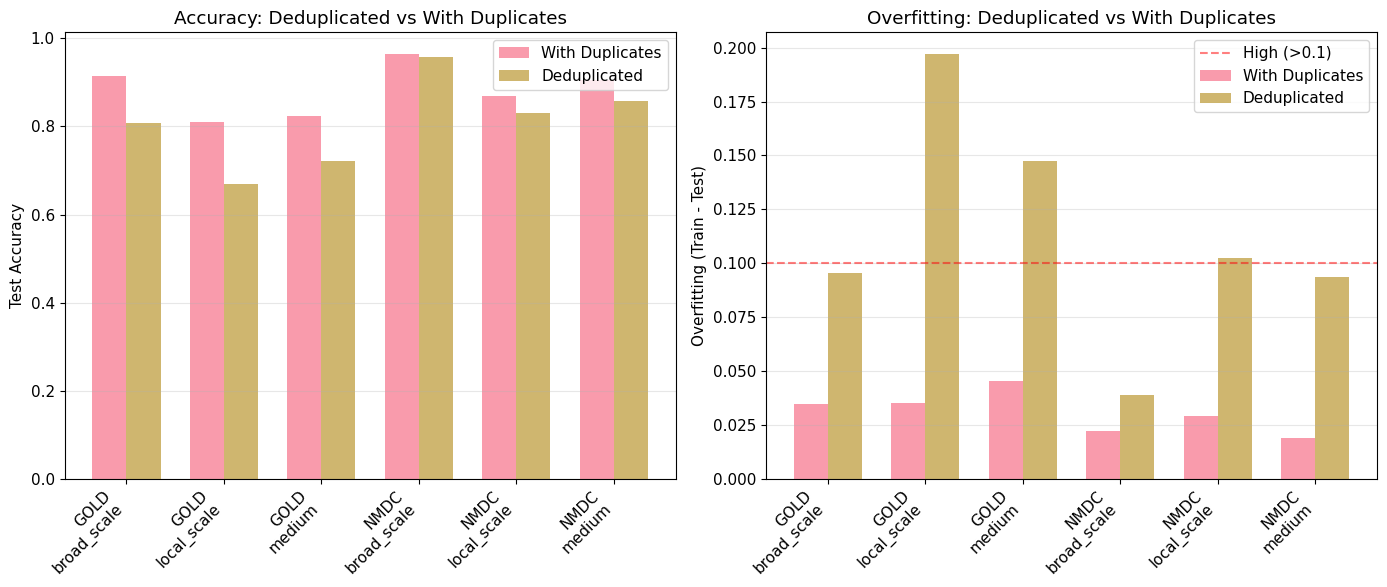

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
x = range(len(dedup_comparison))
width = 0.35
ax1.bar([i - width / 2 for i in x], dedup_comparison['NoDedup_Acc'],
        width, label='With Duplicates', alpha=0.7)
ax1.bar([i + width / 2 for i in x], dedup_comparison['Dedup_Acc'],
        width, label='Deduplicated', alpha=0.7)
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Accuracy: Deduplicated vs With Duplicates')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{row['Source']}\n{row['Scale']}"
                     for _, row in dedup_comparison.iterrows()], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Overfitting comparison
ax2.bar([i - width / 2 for i in x], dedup_comparison['NoDedup_Overfit'],
        width, label='With Duplicates', alpha=0.7)
ax2.bar([i + width / 2 for i in x], dedup_comparison['Dedup_Overfit'],
        width, label='Deduplicated', alpha=0.7)
ax2.set_ylabel('Overfitting (Train - Test)')
ax2.set_title('Overfitting: Deduplicated vs With Duplicates')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{row['Source']}\n{row['Scale']}"
                     for _, row in dedup_comparison.iterrows()], rotation=45, ha='right')
ax2.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High (>0.1)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Per-Class Performance Analysis

In [28]:
# Extract all per-class metrics including specificity
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix

all_class_metrics = []

for source_name in all_results:
  for scale in ['env_broad_scale', 'env_local_scale', 'env_medium']:
    if scale not in all_results[source_name]:
      continue

    result = all_results[source_name][scale]
    class_report = result['class_report']
    y_test = result['y_test']
    y_test_pred = result['y_test_pred']

    # Get unique classes in test set
    unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))

    # Compute per-class confusion matrices to get specificity
    # For multi-class, convert to binary (one-vs-rest) for each class
    mcm = multilabel_confusion_matrix(y_test, y_test_pred, labels=unique_classes)

    # Extract metrics for each class
    for i, class_label in enumerate(unique_classes):
      if class_label in class_report:
        metrics = class_report[class_label]

        # Get confusion matrix for this class (one-vs-rest)
        tn, fp, fn, tp = mcm[i].ravel()

        # Compute specificity = TN / (TN + FP)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        all_class_metrics.append({
          'Source': source_name,
          'Scale': scale.replace('env_', ''),
          'Class': class_label,
          'Precision': metrics['precision'],
          'Recall_Sensitivity': metrics['recall'],
          'Specificity': specificity,
          'F1': metrics['f1-score'],
          'Support': int(metrics['support'])
        })

# Create DataFrame
per_class_df = pd.DataFrame(all_class_metrics)

# Save to TSV
output_file = output_dir / 'per_class_metrics.tsv'
per_class_df.to_csv(output_file, sep='\t', index=False)

print(f"\nPer-class metrics saved to: {output_file}")
print(f"Total rows: {len(per_class_df):,}")
print(f"\nSample of data:")
print(per_class_df.head(10).to_string(index=False))


Per-class metrics saved to: ../results/rf_multi_source/per_class_metrics.tsv
Total rows: 2,109

Sample of data:
Source       Scale         Class  Precision  Recall_Sensitivity  Specificity       F1  Support
  GOLD broad_scale ENVO:00000044   0.000000            0.000000     1.000000 0.000000        1
  GOLD broad_scale ENVO:00000446   0.875445            0.734328     0.930693 0.798701      335
  GOLD broad_scale ENVO:00000447   0.942308            0.942308     0.996193 0.942308       52
  GOLD broad_scale ENVO:00000873   1.000000            0.620690     1.000000 0.765957       29
  GOLD broad_scale ENVO:00002030   0.857143            0.750000     0.996324 0.800000       24
  GOLD broad_scale ENVO:01000020   0.588235            0.909091     0.991556 0.714286       11
  GOLD broad_scale ENVO:01000024   0.875000            1.000000     0.998800 0.933333        7
  GOLD broad_scale ENVO:01000030   1.000000            1.000000     1.000000 1.000000        1
  GOLD broad_scale ENVO:01000035